# Calculate Field Energy of Randomly Dispersed HP1s

### Navigate to root directory

In [1]:
# Built-in modules
import os
import sys

# Insert package root to system path
cwd = os.getcwd()
parent_dir = cwd + "/../.."
sys.path.insert(1, parent_dir)

print("Directory containing the notebook:")
print(cwd)

Directory containing the notebook:
/home/users/jwakim/CodeDev/chromo_check_density_calculation/doc/tools


In [2]:
# Change working directory to package root
os.chdir(parent_dir)
print("Root Directory of Package: ")
print(os.getcwd())

Root Directory of Package: 
/home/users/jwakim/CodeDev/chromo_check_density_calculation


### Import modules

In [3]:
# External modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Package modules
import chromo.mc as mc
from chromo.polymers import Chromatin
import chromo.binders
from chromo.fields import (
    UniformDensityField, get_blocks, get_neighboring_bins, assign_beads_to_bins
)
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.poly_stat as ps

### Specify reader proteins

In [4]:
hp1 = chromo.binders.get_by_name("HP1")
binders = chromo.binders.make_binder_collection([hp1])

### Specify confinement

In [5]:
confine_type = "Spherical"
radii = np.arange(200, 901, 100)

### Specify random walk polymer

In [6]:
num_beads = 100000
bead_spacing = 16.5

chemical_mods = np.atleast_2d(np.ones(num_beads, dtype=int)).T
states = chemical_mods.copy()

### Initialize polymer and calculate field energy

In [7]:
%%capture

udfs = []
chromatins = []
out_dirs = []

for i, confine_length in enumerate(radii):

    chromatin = Chromatin.confined_gaussian_walk(
        'Chr-1',
        num_beads,
        bead_spacing,
        states=states,
        confine_type=confine_type,
        confine_length=confine_length,
        binder_names=np.array(['HP1']),
        chemical_mods=chemical_mods,
        chemical_mod_names=np.array(['H3K9me3'])
    )

    n_bins_x = 63
    n_bins_y = n_bins_x
    n_bins_z = n_bins_x

    x_width = 2 * confine_length
    y_width = x_width
    z_width = x_width

    udf = UniformDensityField(
        polymers = [chromatin],
        binders = binders,
        x_width = x_width,
        nx = n_bins_x,
        y_width = y_width,
        ny = n_bins_y,
        z_width = z_width,
        nz = n_bins_z,
        confine_type = confine_type,
        confine_length = confine_length,
        chi = 1
    )

    chromatins.append(chromatin)
    udfs.append(udf)

    amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(polymers = [chromatin])
    num_snapshots = 1
    mc_steps_per_snapshot = 1

    latest_sim = get_unique_subfolder_name("output/sim_")
    out_dirs.append(latest_sim)
    moves_to_use = ctrl.all_moves(
        log_dir=latest_sim,
        bead_amp_bounds=amp_bead_bounds.bounds,
        move_amp_bounds=amp_move_bounds.bounds,
        controller=ctrl.SimpleControl
    )

    for move_controller in moves_to_use:
        move_controller.move.num_per_cycle = 1

    mc.polymer_in_field(
        polymers = [chromatin],
        binders = binders,
        field = udf,
        num_save_mc = mc_steps_per_snapshot,
        num_saves = num_snapshots,
        bead_amp_bounds = amp_bead_bounds,
        move_amp_bounds = amp_move_bounds,
        output_dir = 'output',
        mc_move_controllers = moves_to_use
    )

### Calculate field energy

In [8]:
confine_lengths = []
field_energies = []

for h, out_dir in enumerate(out_dirs):

    chromatin = chromatins[h]

    output_files = os.listdir(out_dir)
    output_files = [
        f for f in output_files if f.endswith(".csv") and f.startswith("Chr")
    ]
    snapshot = [int(f.split("-")[-1].split(".")[0]) for f in output_files]
    sorted_snap = np.sort(np.array(snapshot))
    output_files = [f for _, f in sorted(zip(snapshot, output_files))]

    for i, f in enumerate(output_files):
        snap = sorted_snap[i]
        output_path = str(out_dir) + '/' + f

        r = pd.read_csv(
            output_path,
            header=None,
            skiprows=2,
            usecols=[1, 2, 3],
            dtype=float
        ).to_numpy()

        t3 = pd.read_csv(
            output_path,
            header=None,
            skiprows=2,
            usecols=[4, 5, 6],
            dtype=float
        ).to_numpy()

        states = pd.read_csv(
            output_path,
            header=None,
            skiprows=2,
            usecols=[10],
            dtype=int
        ).to_numpy()

        chromatin.r = r.copy()
        chromatin.t3 = t3.copy()
        chromatin.states = states.copy()

        field_energy = udfs[h].compute_E(chromatin)
        if field_energy < 1E90:
            confine_lengths.append(radii[h])
            field_energies.append(field_energy)

confine_lengths = np.array(confine_lengths)
field_energies = np.array(field_energies)

print("Confinement Radii:")
print(confine_lengths)
print("Field Energies:")
print(field_energies)

Confinement Radii:
[300 400 500 600 700 800 900]
Field Energies:
[-34242.039456   -17711.11419017 -11713.54148582  -8953.8094986
  -7281.46395852  -5913.91873624  -4990.06349467]


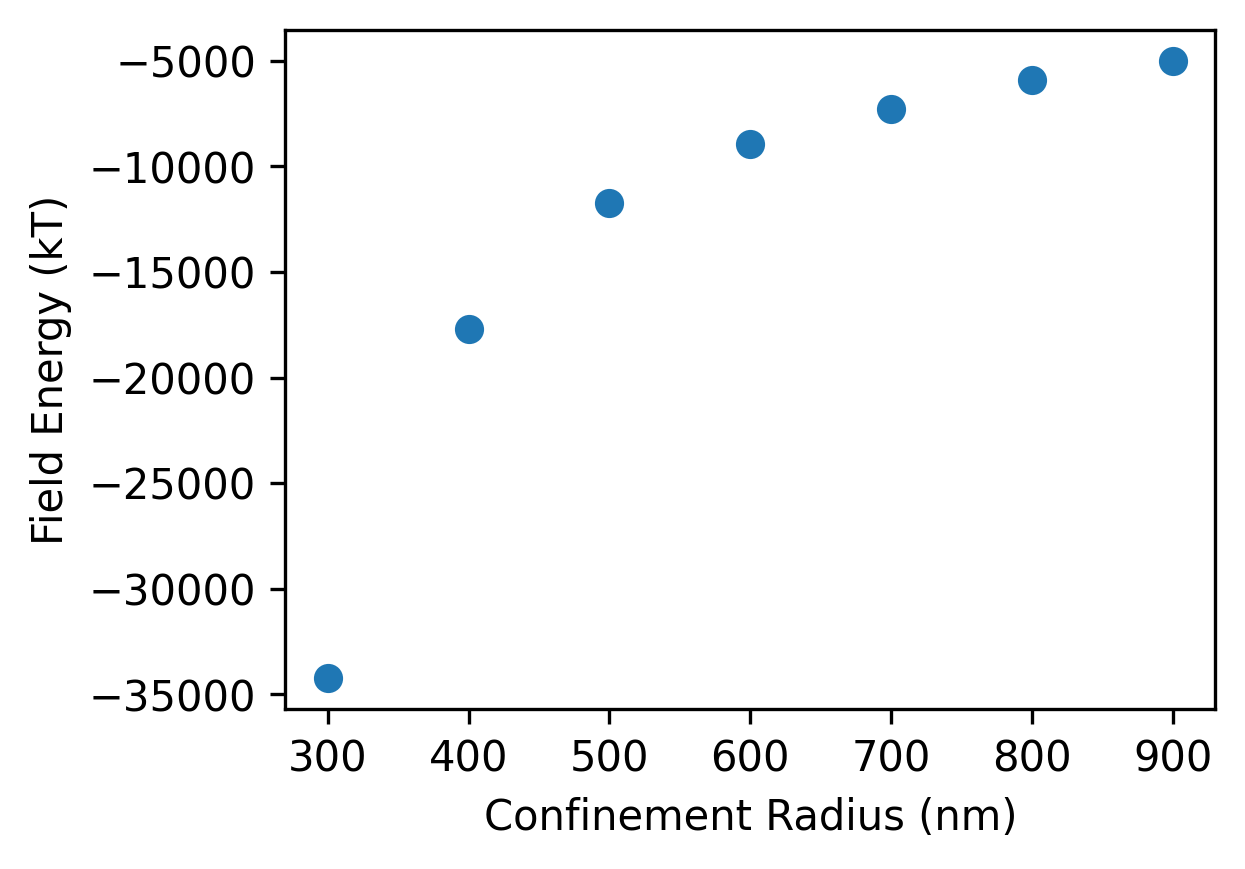

In [9]:
plt.figure(figsize=(4,3), dpi=300)
plt.scatter(confine_lengths, field_energies)
plt.xlabel("Confinement Radius (nm)")
plt.ylabel("Field Energy (kT)")
plt.show()

/home/users/jwakim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


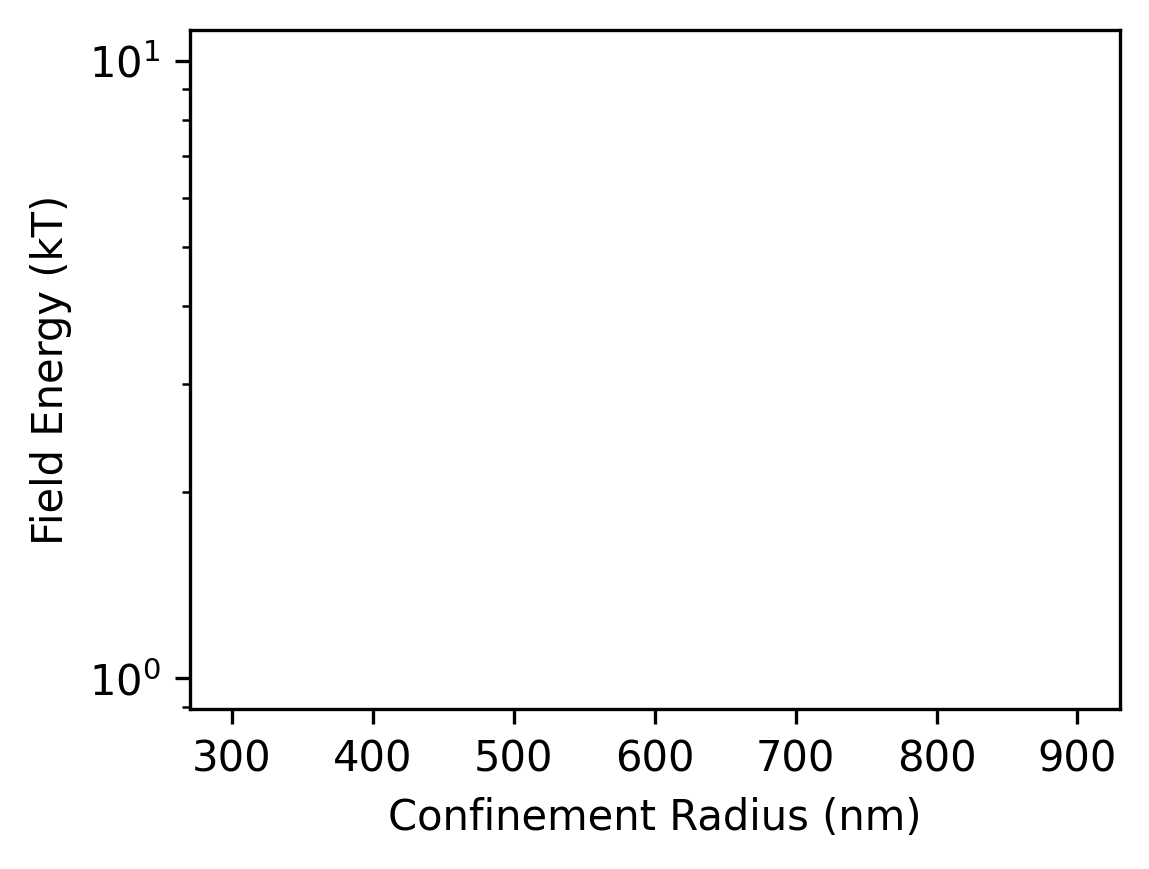

In [10]:
scaling = np.min(field_energies)

plt.figure(figsize=(4,3), dpi=300)
plt.scatter(confine_lengths, field_energies - scaling)
plt.xlabel("Confinement Radius (nm)")
plt.ylabel("Field Energy (kT)")
plt.yscale("log")
plt.show()

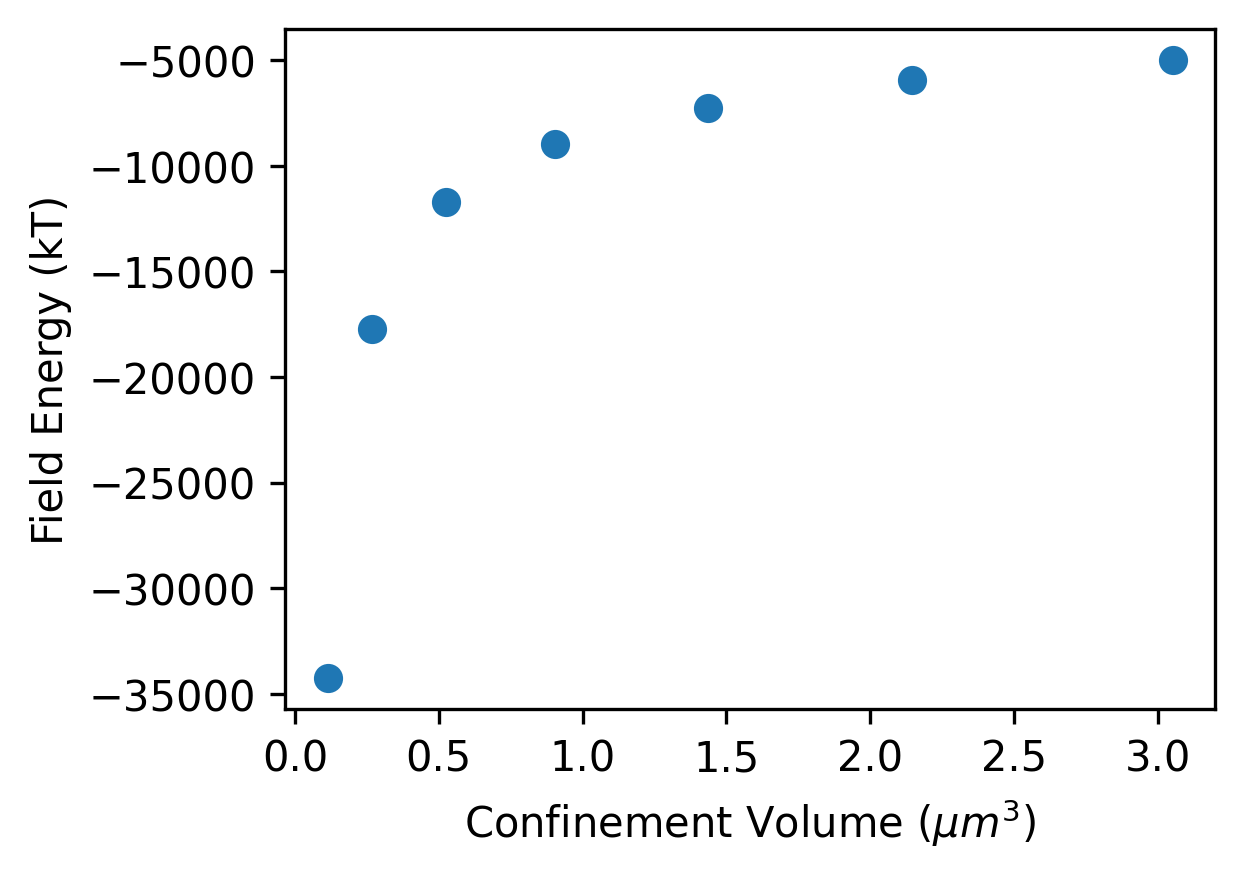

In [25]:
import numpy as np
import matplotlib.pyplot as plt

radii = np.array([300, 400, 500, 600, 700, 800, 900])
field_energies = np.array([
    -34242.039456, -17711.11419017, -11713.54148582, -8953.8094986,
    -7281.46395852, -5913.91873624, -4990.06349467
])

scaling = np.min(field_energies)

plt.figure(figsize=(4,3), dpi=300)
plt.scatter((4/3 * np.pi * radii**3) * 10**-9, field_energies)
plt.xlabel(r"Confinement Volume ($\mu m^3$)")
plt.ylabel("Field Energy (kT)")
plt.show()

/Users/jwakim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


-0.006574122934349983


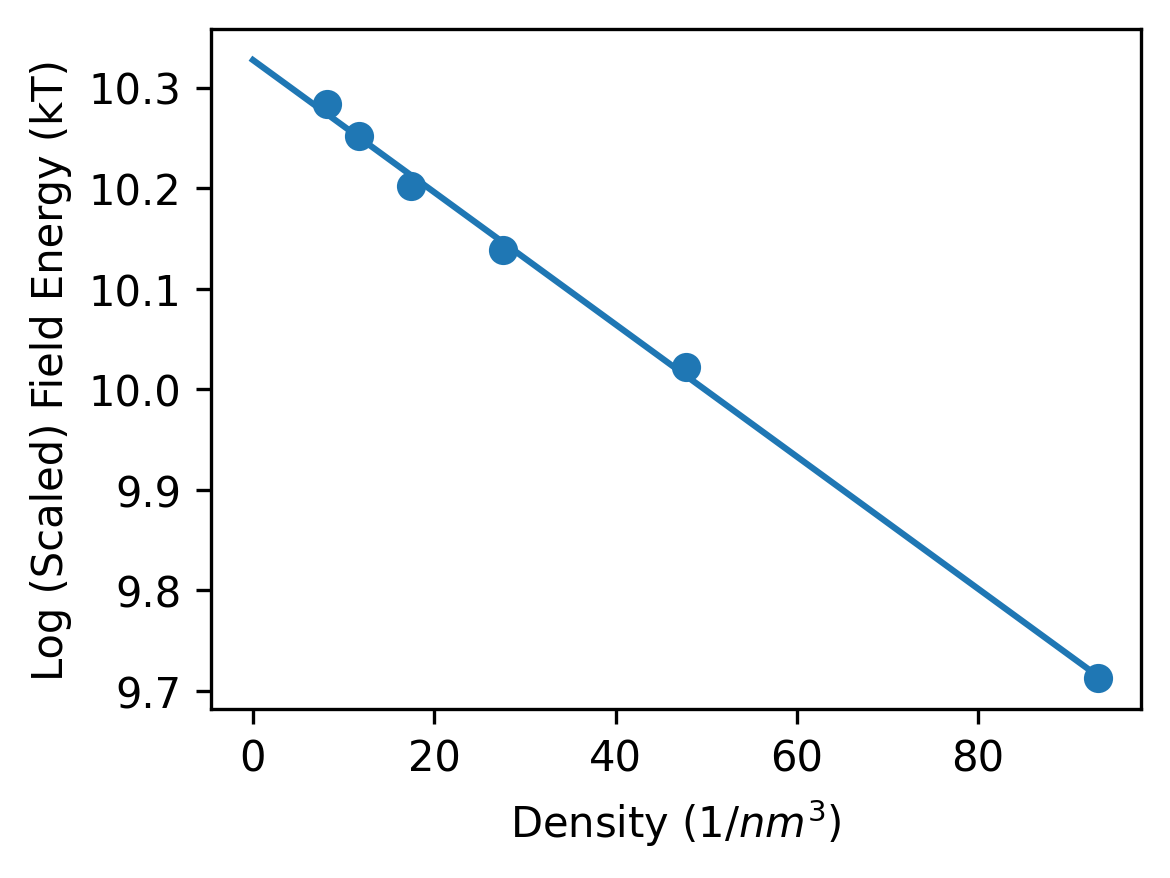

In [39]:
import numpy as np
import matplotlib.pyplot as plt

radii = np.array([300, 400, 500, 600, 700, 800, 900])
field_energies = np.array([
    -34242.039456, -17711.11419017, -11713.54148582, -8953.8094986,
    -7281.46395852, -5913.91873624, -4990.06349467
])

scaling = np.min(field_energies)

densities = 100000/(4/3 * np.pi * radii**3 / (63**3))[1:]
log_scaled_field_energies = np.log(field_energies - scaling)[1:]

m, b = np.polyfit(densities, log_scaled_field_energies, 1)
print(m)

plt.figure(figsize=(4,3), dpi=300)
plt.scatter(densities, log_scaled_field_energies)
plt.plot(np.linspace(0, np.max(densities), 1000), b + m * np.linspace(0, np.max(densities), 1000))
plt.xlabel(r"Average Voxel Density ($1/nm^{3}$)")
plt.ylabel("Log (Scaled) Field Energy (kT)")
plt.show()